# Data Mining in Action 2016 (осенний семестр)

## Задача на семинар: цветовая сегментация кожи на изображении

В этом примере мы построим простой классификатор с использованием библиотеки scikit-learn. В качестве данных мы возьмем выборку из UCI Репозитория (www.archive.ics.uci.edu), связанную с задачей сегментации изображений, а точнее - выделением кожи на фотографиях. 

В итоге мы получим классификатор, который по RBG представлению цвета пикселя будет пытаться определить, принадлежит пиксель к участку кожи или нет.

<img src="skin_segmentation2.png" />

Для начала скачаем выборку по следующей ссылке: https://archive.ics.uci.edu/ml/machine-learning-databases/00229/Skin_NonSkin.txt

In [2]:
!curl https://archive.ics.uci.edu/ml/machine-learning-databases/00229/Skin_NonSkin.txt > Skin_NonSkin.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3321k  100 3321k    0     0   418k      0  0:00:07  0:00:07 --:--:--  685k


## Задаем кодировку

В Python кодировка файла скрипта задается с помощью так называемого magic comment: # coding: utf-8
(либо другая кодировка по необходимости).

Волшебный комментарий должен быть в первых двух строчках скрипта, иначе он игнорируется интерпретатором. Добавив этот комментарий в скрипт можно, например, комфортно использовать в коде русскоязычные строки и комментарии. Однако для ipython notebook такой способ не подходит ведь разные блоки кода могут исполняться в разной последовательности. Есть другой способ, им и воспользуемся:

In [13]:
import sys
reload(sys)
sys.setdefaultencoding("utf-8")

После исполнения этого блока проблем с русскоязычными комментариями в коде быть не должно.

## Чтение выборки

Давайте посмотрим на выборку и попробуем понять, какой смысл имеют

In [3]:
dataset_path = "Skin_NonSkin.txt"
dataset_file = open(dataset_path, 'r')
dataset_text = dataset_file.read().split('\n')


In [4]:
dataset = [map(int, line.split('\t')) for line in dataset_text if len(line) > 0]
print dataset[:10]

[[74, 85, 123, 1], [73, 84, 122, 1], [72, 83, 121, 1], [70, 81, 119, 1], [70, 81, 119, 1], [69, 80, 118, 1], [70, 81, 119, 1], [70, 81, 119, 1], [76, 87, 125, 1], [76, 87, 125, 1]]


In [5]:
X = [line[:-1] for line in dataset]
y = [line[-1] for line in dataset]

print X[:5]

#print "123",

print y[:5]

[[74, 85, 123], [73, 84, 122], [72, 83, 121], [70, 81, 119], [70, 81, 119]]
[1, 1, 1, 1, 1]


In [6]:
import numpy as np

np.random.seed(0)
indices = np.random.permutation(len(X))
X = np.array(X)
y = np.array(y)
test_size = 100000
X_train = X[indices[:-test_size]]
y_train = y[indices[:-test_size]]
X_test  = X[indices[-test_size:]]
y_test  = y[indices[-test_size:]]


In [7]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
model.fit(X_train, y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [8]:
predicted = model.predict(X_test)
print predicted[:10]

[2 2 1 1 2 1 2 2 1 2]


In [9]:
print float(sum(y_test == predicted))/test_size

0.99948


## Чтение и обработка изображения

Для работы с графиками и изображениями в Python есть библиотека Matplotlib. На сайте библиотеки www.matplotlib.org описан API и есть большое количество примеров в разделе gallery. При необходимости построить график можно зайти в галерею, найти визуально картинку, наиболее похожую на нужную и посмотреть код.

Но сейчас мы воспользуемся matplotlib для работы с изображением, на котором хотим найти участки кожи. Для начала считаем изображение:

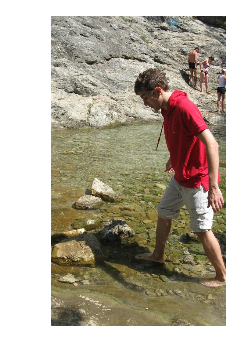

In [10]:
%matplotlib inline 
# чтобы изображения выводились прямо в ipython notebook, а не в отдельном окне


import matplotlib.pyplot as plt
import matplotlib.cbook as cbook

image_path = "kantor.jpg"

image_file = open(image_path, 'rb')
#image_file = cbook.get_sample_data(image_path)
image = plt.imread(image_file)

plt.imshow(image)
plt.axis('off') # clear x- and y-axes
plt.show()

Посмотрим, в каком формате хранится изображение в переменой image:

In [51]:
print type(image)

<type 'numpy.ndarray'>


Поскольку это массив, попробуем вывести несколько его первых элементов:

In [11]:
print image[:3]

[[[133 119 116]
  [123 109 106]
  [147 133 130]
  ..., 
  [129 131 120]
  [126 130 116]
  [121 125 111]]

 [[176 165 161]
  [146 135 131]
  [165 154 150]
  ..., 
  [125 128 117]
  [145 148 137]
  [128 131 120]]

 [[168 160 157]
  [150 142 139]
  [150 142 139]
  ..., 
  [ 67  73  61]
  [ 76  82  70]
  [ 61  67  55]]]


Похоже на массив строк пикселей. Каждая строка - массив пикселей, а пиксель - массив из трех чисел - RGB представления цвета пикселя.

Обучим наш классификатор на всей обучающей выборке и прогоним классификатор по всем пикселям изображения, заменяя пиксели кожи на ярко зелёные:

In [12]:
model.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [13]:
for i, line in enumerate(image):
    classes = model.predict(line) # predict принимает список объектов
    for j, ans in enumerate(classes):
        if ans == 1:
            image[i, j, 0] = image[i, j, 2] = 0
            image[i, j, 1] = 255

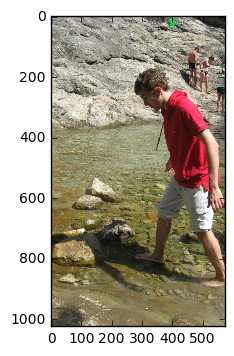

In [14]:
plt.imshow(image)
plt.show()

Не правда ли, какой-то подозрительный результат?

## Задание

#### На семинаре:

1. Выяснить, почему на изображении не выделились участки кожи и исправить ситуацию. Подсказка: читайте документацию библиотек либо пробуйте визуализировать цвета, которые классификатор относит к коже. Блокнот с решением проблемы выложить на github.
1. Сравнить качество на отложенной выборке при разном количестве соседей k в kNN (от 1 до 10) и при разных весах во взвешенной версии kNN (см. документацию scikit-learn). 
1. Блокнот с исправлением детектирования кожи и экспериментами выслать на datamininginaction@gmail.com

#### Дополнительные задания (к следующему занятию):

1. С помощью matplotlib построить трёхмерную визуализацию выборки и выслать на тот же адрес.
1. Разобрать презенташку про numpy, scipy, matplotlib: http://mit.spbau.ru/files/scipy.pdf
1. Разобрать Crash Course in Python for scientists.